# Introduction to Zonal Statistics

**What does this notebook do?** 
This notebook demonstrates how to conduct zonal statistics of MODIS data from a vector data (e.g., Australian Marine Parks). The results are shown as table and graph, and exported as CSV files.

**Requirements** 
You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

module use /g/data/v10/public/modules/modulefiles

module load dea

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository README for instructions on creating a Pull request).

**Date:** last updated 16th, Jan, 2019

**Author:** Zhi Huang

**Import modules**

In [2]:
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
%matplotlib inline
import fiona
from shapely import geometry
from datacube.utils import geometry
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
from affine import Affine
from datacube.helpers import write_geotiff
import pandas as pd

**Specify a development database to connect to. It is on a different database server agdstaging-db.nci.org.au, which means that your ~/.pgpass file will need to specify a password to connect to it as well.**

In [3]:
dc = Datacube(config='/g/data/u46/users/dsg547/modis_oc.conf')

**The only product in this database is the daily ocean colour data between 2002 and 2018.**

In [4]:
dc.list_products()

,name,description,platform,label,lat,lon,product_type,instrument,time,format,creation_time,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
5,modis_oc_1d,MODIS Ocean Cover Daily,MODIS,None,None,None,modis_oc_1d,None,None,None,None,EPSG:4326,"(-0.01, 0.01)",None,"(latitude, longitude)"


**These are the available measurements**

In [6]:
dc.list_measurements()

dtype                 name  nodata  \
product     measurement                                                 
modis_oc_1d K_490                float32                K_490  -999.0   
            chl_gsm              float32              chl_gsm  -999.0   
            chl_oc3              float32              chl_oc3  -999.0   
            dt                   float32                   dt  -999.0   
            ipar                 float32                 ipar  -999.0   
            l2_flags               int32             l2_flags    -1.0   
            nanop_brewin2010at   float32   nanop_brewin2010at  -999.0   
            nanop_brewin2012in   float32   nanop_brewin2012in  -999.0   
            npp_vgpm_eppley_gsm  float32  npp_vgpm_eppley_gsm  -999.0   
            npp_vgpm_eppley_oc3  float32  npp_vgpm_eppley_oc3  -999.0   
            owtd                    int8                 owtd    -1.0   
            par                  float32                  par  -999.0   
            picop_brewin2010at   float32   picop_brewin2010at  -999.0   
            picop_brewin2012in   float32   picop_brewin2012in  -999.0   
            sst                  float32                  sst  -999.0   
            sst_quality            int16          sst_quality    -1.0   

                                                          units  
product     measurement                                          
modis_oc_1d K_490                                          m^-1  
            chl_gsm                                      mg/m^3  
            chl_oc3                                      mg/m^3  
            dt                   days since 2016-01-01 00:00:00  
            ipar                                  Ein m^-2 s^-1  
            l2_flags                                          1  
            nanop_brewin2010at                          percent  
            nanop_brewin2012in                          percent  
            npp_vgpm_eppley_gsm                    mg.m^-3.d^-1  
            npp_vgpm_eppley_oc3                    mg.m^-3.d^-1  
            owtd                                              1  
            par                                 Ein m^-2 day^-1  
            picop_brewin2010at                          percent  
            picop_brewin2012in                          percent  
            sst                                         Celsius  
            sst_quality                                       1

**Load 15 days of SST (Sea Surface Temperature) and CHL_GSM (Chlorophyll _a_) data from the start of 2016. Note that the resolution has been resampled from 0.01 dd to 0.1 dd to save memory usage.**

In [5]:
data = dc.load(product='modis_oc_1d', time=('2016-01-01', '2016-01-15'), resolution=(-0.1, 0.1), measurements=('sst','chl_gsm'))

**Mask the nodata (-999) as 'nan'**

In [6]:
data = mask_invalid_data(data)

**Try merging the data together every 5 days to fill in the gaps**

In [7]:
data2 = data.resample(time='5D').mean()

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [8]:
data2

<xarray.Dataset>
Dimensions:    (latitude: 701, longitude: 1001, time: 3)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-01T11:59:59.999999 ... 2016-01-11T11:59:59.999999
  * latitude   (latitude) float64 10.05 9.95 9.85 9.75 ... -59.75 -59.85 -59.95
  * longitude  (longitude) float64 79.95 80.05 80.15 80.25 ... 179.8 179.9 179.9
Data variables:
    sst        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    chl_gsm    (time, latitude, longitude) float32 nan nan nan ... nan nan nan

**Plot the 5-days compsites**

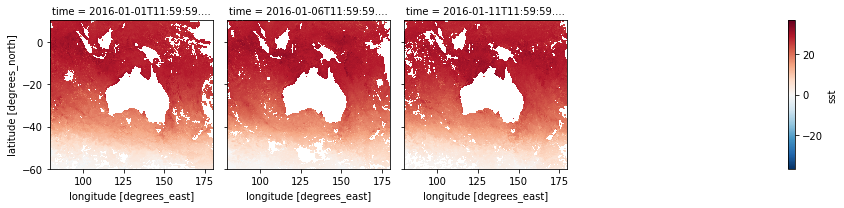

In [9]:
data2.sst.plot(col='time',col_wrap=4)

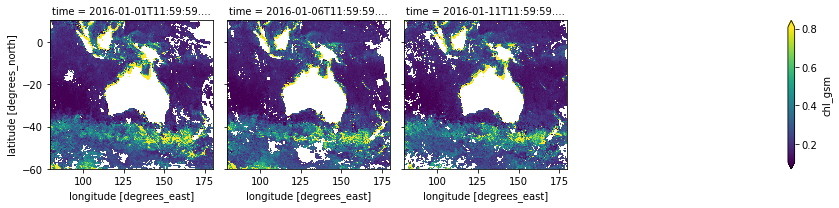

In [17]:
data2.chl_gsm.plot(col='time',col_wrap=4,robust=True)

**load the vector data, Lord Howe Marine Park**

In [9]:
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/LH_AMP.shp'

In [10]:
#open the polygon
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)


**plot the polygon to check it looks ok**

<Figure size 432x288 with 0 Axes>

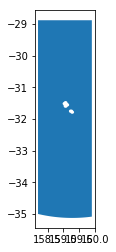

In [12]:
#plot polygon to check it looks ok
plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot()

plt.show()


**need to assign crs attribute to data2, as it does not inherit the attribute from data**

In [13]:
## assign crs attribute for data2
data2.attrs['crs']=data.crs

**The affine attribute is a required input for the zonal_stats()**

In [14]:
data2.affine

Affine(0.09999999999999999, 0.0, 79.9,
       0.0, -0.1, 10.100000000000001)

## conduct zonal statstists using the zonal_stats() from rasterstats package

**generate zonal statstists on the second item of SST data (5-D mean)**

In [15]:
stats = zonal_stats(poly_path,data2.sst[1].data,affine=data2.affine)

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


**The default outputs include: min, max, mean and count**

In [16]:
stats

[{'min': 19.735000610351562,
  'max': 25.075000762939453,
  'mean': 22.57846515357089,
  'count': 588}]

**load the vector data representing all Australian Marine Parks**

In [18]:
AMPs_path = '/home/547/zxh547/dea-notebooks/shapefiles/AMP_boundaries_zones.shp'

**generate more statistics, and include all existing attributes of the vector data using the geojson_out option**

In [19]:
stats3 = zonal_stats(AMPs_path,data2.sst[1].data,affine=data2.affine,stats=['min','max','mean','range','median','std','sum','count'],geojson_out=True)

## list results as table, as DataFrame object

In [20]:
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
propertiesList = []
for f in stats3:
    propertiesList.append(f['properties'])
df = pd.DataFrame(propertiesList)

**shows the zonal statistics table**

In [182]:
df

,OBJECTID,NETNAME,RESNAME,ZONENAME,ZONEIUCN,POLYGONID,NATLEGEND,AREA_KM2,Shape_Leng,Shape_Area,min,max,mean,count,sum,std,median,range
0,1,South-west,Bremer,National Park Zone,II,swbrenpz01,National Park Zone (IUCN II),3172.431274,3.267549,0.312671,19.002499,20.630001,19.430699,31,602.351669,0.371601,19.347500,1.627502
1,2,Coral Sea,Coral Sea,National Park Zone,II,cscspnpz03,National Park Zone (IUCN II),1036.357663,1.223454,0.086665,29.626669,30.844999,29.935741,9,269.421671,0.360868,29.797501,1.218330
2,3,Coral Sea,Coral Sea,Habitat Protection Zone,IV,cscsphpz01,Habitat Protection Zone (IUCN IV),11963.758746,5.573777,0.988163,28.684999,30.564999,29.668628,96,2848.188318,0.396894,29.646249,1.879999
3,4,North-west,Roebuck,Multiple Use Zone,VI,nwroemuz01,Multiple Use Zone (IUCN VI),303.705433,0.795021,0.025927,31.362499,31.835001,31.642501,3,94.927502,0.202578,31.730001,0.472502
4,5,North-west,Mermaid Reef,National Park Zone,II,nwmernpz01,National Park Zone (IUCN II),539.873617,0.866667,0.045833,29.322500,29.677500,29.471875,4,117.887501,0.129956,29.443750,0.355000
5,6,North-west,Argo-Rowley Terrace,Multiple Use Zone,VI,nwartmuz03,Multiple Use Zone (IUCN VI),4480.950983,4.429526,0.381214,28.816668,29.407501,29.122450,33,961.040836,0.140722,29.112499,0.590834
6,7,North-west,Argo-Rowley Terrace,National Park Zone,II,nwartnpz01,National Park Zone (IUCN II),36050.134308,9.106808,3.020640,28.850000,31.215000,30.142015,201,6058.544998,0.593265,30.254999,2.365000
7,8,North-west,Argo-Rowley Terrace,Special Purpose Zone (Trawl),VI,nwartspt04,Special Purpose Zone (Trawl) (IUCN VI),1140.772685,2.659908,0.096874,29.100000,29.752501,29.329849,11,322.628334,0.195210,29.312500,0.652500
8,9,North-west,Argo-Rowley Terrace,Multiple Use Zone,VI,nwartmuz02,Multiple Use Zone (IUCN VI),104331.088257,14.883481,8.816683,27.959999,31.905001,29.403044,692,20346.906696,0.631822,29.379999,3.945002
9,10,North-west,Kimberley,Habitat Protection Zone,IV,nwkimhpz03,Habitat Protection Zone (IUCN IV),3982.264206,2.833491,0.336361,29.434999,30.889999,30.252957,31,937.841663,0.311946,30.297501,1.455000


**only list those records with mean SST > 30**

In [185]:
df[df['mean']>30]

,OBJECTID,NETNAME,RESNAME,ZONENAME,ZONEIUCN,POLYGONID,NATLEGEND,AREA_KM2,Shape_Leng,Shape_Area,min,max,mean,count,sum,std,median,range
3,4,North-west,Roebuck,Multiple Use Zone,VI,nwroemuz01,Multiple Use Zone (IUCN VI),303.705433,0.795021,0.025927,31.362499,31.835001,31.642501,3,94.927502,0.202578,31.730001,0.472502
6,7,North-west,Argo-Rowley Terrace,National Park Zone,II,nwartnpz01,National Park Zone (IUCN II),36050.134308,9.106808,3.020640,28.850000,31.215000,30.142015,201,6058.544998,0.593265,30.254999,2.365000
9,10,North-west,Kimberley,Habitat Protection Zone,IV,nwkimhpz03,Habitat Protection Zone (IUCN IV),3982.264206,2.833491,0.336361,29.434999,30.889999,30.252957,31,937.841663,0.311946,30.297501,1.455000
10,11,North-west,Kimberley,National Park Zone,II,nwkimnpz02,National Park Zone (IUCN II),6392.302461,5.934176,0.538676,29.022499,31.415001,30.268350,49,1483.149164,0.475037,30.260000,2.392502
14,15,North-west,Ashmore Reef,Sanctuary Zone,Ia,nwashsan01,Sanctuary Zone (IUCN Ia),549.642971,1.114663,0.045665,30.313334,30.313334,30.313334,1,30.313334,0.000000,30.313334,0.000000
38,39,North,Joseph Bonaparte Gulf,Special Purpose Zone,VI,nojbgspz01,Special Purpose Zone (IUCN VI),2251.462089,2.089307,0.188249,29.860001,30.605000,30.121428,7,210.849998,0.264625,29.924999,0.744999
42,43,Coral Sea,Coral Sea,Habitat Protection Zone (Reefs),IV,cscsphpr04,Habitat Protection Zone (Reefs) (IUCN IV),417.555547,0.921372,0.034960,29.385000,30.920000,30.052500,3,90.157501,0.642420,29.852501,1.535000
50,51,North,Oceanic Shoals,Multiple Use Zone,VI,noocsmuz03,Multiple Use Zone (IUCN VI),32486.311732,6.455756,2.696983,28.590000,31.934999,30.259938,230,6959.785830,0.569660,30.298750,3.344999
70,71,North,Limmen,Habitat Protection Zone,IV,nolimhpz01,Habitat Protection Zone (IUCN IV),1399.196914,1.828178,0.117646,30.469999,33.815002,31.357885,13,407.652504,0.808569,31.215000,3.345003
89,90,North-west,Cartier Island,Sanctuary Zone,Ia,nwcaisan01,Sanctuary Zone (IUCN Ia),172.374499,0.424494,0.014337,30.799999,30.799999,30.799999,1,30.799999,0.000000,30.799999,0.000000


**list those records with mean SST > 29, only with two columns: RESNAME and mean**

In [21]:
df1=df[df['mean']>29][['RESNAME','mean']]

In [22]:
df1

,RESNAME,mean
1,Coral Sea,29.935741
2,Coral Sea,29.668628
3,Roebuck,31.642501
4,Mermaid Reef,29.471875
5,Argo-Rowley Terrace,29.122450
6,Argo-Rowley Terrace,30.142015
7,Argo-Rowley Terrace,29.329849
8,Argo-Rowley Terrace,29.403044
9,Kimberley,30.252957
10,Kimberley,30.268350


**plot mean SST of RESNAME as bars**

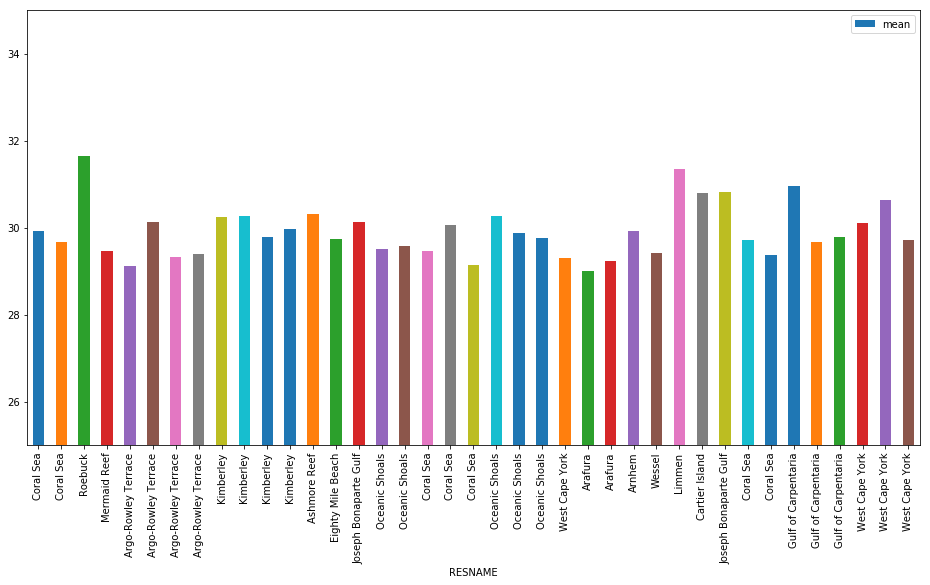

In [24]:
df1.plot(kind='bar',x='RESNAME',y='mean',ylim=(25,35), figsize=(16,8))

## export to csv file

**export the zonal statistics table (only one table) to a csv file**

In [25]:
df.to_csv("/home/547/zxh547/dea-notebooks/AMPs_SST_test.csv",na_rep="-999",index=False)

**export multiple zonal statistics tables to csv files. In this case, 15 tables correspond to 15 days of SST data loaded initially.**

In [261]:
import pandas as pd
AMPs_path = '/home/547/zxh547/dea-notebooks/shapefiles/AMP_boundaries_zones.shp'
i = 0

while i < data['sst'].time.size:
    time = str(data['sst'].time[i].data)[:10]
    print(time)
    sst = data.sst[i].data
    stats = zonal_stats(AMPs_path,sst,affine=data.affine,stats=['min','max','mean','range','median','std','sum','count'],geojson_out=True)
    propertiesList = []
    for f in stats:
        propertiesList.append(f['properties'])
    df = pd.DataFrame(propertiesList)
    csvFile = "/home/547/zxh547/dea-notebooks/AMPs_SST_" + time + ".csv"
    df.to_csv(csvFile,na_rep="-999",index=False)
    i = i + 1

2016-01-01
<xarray.DataArray 'sst' ()>
array(19.617645, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-01T11:59:59.999999
here
2016-01-02
<xarray.DataArray 'sst' ()>
array(21.732197, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-02T11:59:59.999999
here
2016-01-03
<xarray.DataArray 'sst' ()>
array(21.265154, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-03T11:59:59.999999
here
2016-01-04
<xarray.DataArray 'sst' ()>
array(22.425545, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-04T11:59:59.999999
here
2016-01-05
<xarray.DataArray 'sst' ()>
array(22.72365, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-05T11:59:59.999999
here
2016-01-06
<xarray.DataArray 'sst' ()>
array(21.734516, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-06T11:59:59.999999
here
2016-01-07
<xarray.DataArray 'sst' ()>
array(22.40963, dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-07T11:59:59.999999